In [1]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
import pytz
from datetime import datetime
from pysolar import solar
import os
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import read_csv, read_excel, DataFrame
from skimage.feature import hessian_matrix_det as Hessian
from skimage.feature import local_binary_pattern as LBP
import pickle
import warnings
warnings.filterwarnings("ignore")
import joblib
import logging
logging.basicConfig(level=logging.INFO)
from utils_segmentation import *

# In[2]:

cmap = mpl.colors.ListedColormap(['y', 'r', 'g','w','b','m','c','k'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6,7,8], cmap.N)

In [2]:
noon_thresh = 20#degrees
start_dates_cook = ['20221028224215',
               '20221108180152',
               '20221125231429',
               '20221229191212',
               '20230301223610',
               '20230320171323',
               '20230522171148',
               '20230525222154',
               '20230601192831',
               '20230602184516']

stop_dates_cook =  ['20221104234238',
               '20221116210712',
               '20221229174156',
               '20230221015754',
               '20230301223630',
               '20230322045000',
               '20230525111517',
               '20230601022210',
               '20230602033124']
start_dates_cprl = ['20230411192131',
                    '20230427001305',
                    '20230607014817',
                    '20230623230336']

stop_dates_cprl =  ['20230426231253',
                    '20230531114644',
                    '20230623180307']

start_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cook]
stop_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cook]

start_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cprl]
stop_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cprl]

In [19]:
model_mlp_v1 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp_v1.pk.sav'), 'rb'))
model_mlp_v2 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp_v2.pk.sav'), 'rb'))

cal_nsar_v0 = pickle.load(open(os.path.join(p3,'calibration_nsar1.pk.sav'), 'rb'))#20220705
cal_nsar_v1 = pickle.load(open(os.path.join(p3,'calibration_nsar2.pk.sav'), 'rb'))#20221122
cal_nsar_v2 = pickle.load(open(os.path.join(p3,'calibration_nsar3.pk.sav'), 'rb'))#20230315
[model0,model1,model2,I0,I1] = pickle.load(open(os.path.join(p3,'calibration_nsar_pwlf.pk.sav'), 'rb'))#20230315

cal_cprl = pickle.load(open(os.path.join(p3,'calibration_cprl1.pk.sav'), 'rb'))#20230305

In [1]:
print('%3.4fx%3.4f'%(cal_cprl.coef_[0][0],cal_cprl.intercept_))
print('%3.4fx%3.4f'%(cal_nsar_v2.coef_[0][0],cal_nsar_v2.intercept_))
print('%3.4fx+%3.4f x<%3.4f'%(model0.coef_[0][0],model0.intercept_,I0))
print('%3.5fx+%3.4f %3.5f<=x<%3.4f'%(model1.coef_[0][0],model1.intercept_,I0,I1))
print('%3.4fx+%3.4f x>=%3.4f'%(model2.coef_[0][0],model2.intercept_,I1))

NameError: name 'cal_cprl' is not defined

In [ ]:
def ir_post(di,ir):
    global model0,model1,model2,I0,I1,cal_cprl,di
    
    return T_ir

In [ ]:
for di, start_dates, stop_dates in zip([p00,p0],[start_dates_cprl,start_dates_cook], [stop_dates_cprl, stop_dates_cook]):
    pred_mlp3=None
    pred_mlp3_noon=None

    lat = np.nan
    lon = np.nan
    ti = 0
    ti_change = True
    imgs=[]
    f_sol_sun = []
    f_sol_shd = []
    f_res_sun = []
    f_res_shd = []
    f_veg_sun = []
    f_veg_shd = []
    f_snw_sun = []
    f_snw_shd = []

    T_sol_sun = []
    T_sol_shd = []
    T_res_sun = []
    T_res_shd = []
    T_veg_sun = []
    T_veg_shd = []
    T_snw_sun = []
    T_snw_shd = []

    elevation = []
    azimuth = []

    times = []
    
    daylight = []

    noon_delta_new = 100
    noon_delta_old = 100
    n_img=0
 
    if di==p00:
        dstXY=np.array([[542,148],[1179.5,127.5],[1197.5,781.5],[533.5,783.5]])
        srcXY=np.array([[48,18],[105.5,17.5],[104.5,76.5],[47.5,76.5]])
        warp_mat = cv2.estimateAffine2D(srcXY,dstXY)
    elif di==p0:
        warp_mat = (np.array([[  7.88031998,   0.28718853,  -6.50989774],
                              [  0.03765769,   7.90500728, -28.32654208]]),
                    np.array([[1],
                              [1],
                              [1],
                              [0]], dtype=np.uint8))
    for version, model in zip(['V1','V2'],[model_mlp3_v1,model_mlp3_v2]):
        f_imgs_ir = list()
        f_imgs_bgr = list()
        utc_ir = list()
        utc_bgr = list()
        for f in os.listdir(os.path.join(di,version)):
            if '.png' in f:

                time_place = f.split('.png')[0].split('_')
                if version=='V1': 
                    t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                elif version=='V2':
                    if di==p0:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                    elif di==p00:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                if '_bgr' in f:
                    f_imgs_bgr.append(f)
                    utc_bgr.append(t_meas)
                if '_ir' in f:
                    f_imgs_ir.append(f)
                    utc_ir.append(t_meas)

        ibgr = np.argsort(utc_bgr)
        iir = np.argsort(utc_ir)
        utc_bgr = np.array(utc_bgr)[ibgr]
        utc_ir = np.array(utc_ir)[iir]
        f_imgs_bgr = np.array(f_imgs_bgr)[ibgr]
        f_imgs_ir = np.array(f_imgs_ir)[iir]

        #find closest IR match to BGR
        idx = []
        for utc, f in zip(utc_bgr,f_imgs_bgr):
            idx.append(np.argmin(np.abs(utc_ir-utc)))

        utc_ir = np.array(utc_ir)[idx]
        f_imgs_ir = np.array(f_imgs_ir)[idx]
        for f_bgr, f_ir in zip(f_imgs_bgr,f_imgs_ir):
            #print(f_bgr)
            bgr = cv2.imread(os.path.join(di,version,f_bgr),cv2.IMREAD_UNCHANGED)
            #filter nighttime
            #20221017084722_-117.081903_46.781495_bgr.png
            time_place = f_bgr.split('_bgr.')[0].split('_')
            if version=='V1':
                utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            elif version=='V2':
                if di==p0:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                elif di==p00:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            if utc>=start_dates[ti] and utc<=stop_dates[ti]: 
                theta = np.nan
                phi = np.nan
                if version == 'V1':
                    if 'nofix' not in time_place:
                        lat = np.double(time_place[2])
                        lon = np.double(time_place[1])
                    elif 'nofix' in time_place and di==p00:
                        #Latitude: 35 ° 11’ 17.45”; Longitude: 102° 5’ 43.98”; elevation : 1168 m
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                elif version == 'V2':
                    if di == p0:
                        lat = 46.781553
                        lon = -117.081863
                    elif di == p00:
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                else:
                    pass
                theta = solar.get_altitude(lat,lon,utc)
                phi = solar.get_azimuth(lat,lon,utc)
                print(utc,phi,theta)
                day = False
                if theta>10.0:
                    day = True
                    feat = get_features(bgr)

                    if not np.any(np.isnan(feat)):
                        pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
                        if plots:
                            plt.imshow(bgr)
                            plt.title('bgr')
                            plt.show()

                            plt.imshow(pred_mlp3, cmap=cmap3, norm=norm3, interpolation='none')
                            plt.title('labels')
                            plt.show()
                    
                    ir_good = False 
                    if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                        ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                        if plots:
                            plt.imshow(ir_raw)
                            plt.title('ir_raw')
                            plt.colorbar()
                            plt.show()
                        if np.std(ir_raw)<1000:
                            ir_good = True
                        else:
                            ir_good = False
                    if ir_good:
                        if di==p0:
                            if utc<start_dates[6] and ti_change:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                try:
                                    warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                except:
                                    pass
                                
                                mask = (pred_mlp3==3) | (pred_mlp3==7)
                        elif di==p00:
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                #warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                mask = (pred_mlp3==3) | (pred_mlp3==7)
                        _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                        if plots:
                            plt.imshow(ir)
                            plt.title('ir')
                            plt.colorbar()
                            plt.show()
                        T_ir = ir.astype(np.float)
                        
                        
                        if di==p0:
                            T_ir = np.piecewise(T_ir, [T_ir < I0, (T_ir>=I0) & (T_ir<I1), T_ir>=I1], [lambda x: model0.intercept_[0]+model0.coef_[0][0]*x, lambda x: model1.intercept_[0]+model1.coef_[0][0]*x, lambda x: model2.intercept_[0]+model2.coef_[0][0]*x])

                            if utc<start_dates[6]:
                                T_ir[mask] = np.nan
                                pred_mlp3[mask] = np.nan
                        elif di==p00:
                            T_ir = T_ir*cal_cprl.coef_+cal_cprl.intercept_
                        
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                T_ir[mask] = np.nan
                                pred_mlp3[mask] = np.nan      
                                
                        T_ir[T_ir==cal.intercept_ or T_ir==model0.intercept_] = np.nan
                        T_ir = T_ir*(1/.98)**(1/4)
                        if plots:
                            plt.imshow(T_ir)

                            plt.colorbar()
                            plt.show()
                    else:
                        T_ir = np.nan*v.reshape(bgr.shape[0:2])

                    noon_delta_new = np.abs(theta-90) 
                    if noon_delta_new<noon_delta_old:#near noon
                        print('noon')
                        pred_mlp3_noon=pred_mlp3.copy()
                    noon_delta_old = noon_delta_new

                    f_sol_sun.append(np.nansum(pred_mlp3==0)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_sol_shd.append(np.nansum(pred_mlp3==4)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_sun.append(np.nansum(pred_mlp3==1)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_shd.append(np.nansum(pred_mlp3==5)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_sun.append(np.nansum(pred_mlp3==2)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_shd.append(np.nansum(pred_mlp3==6)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_sun.append(np.nansum(pred_mlp3==3)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_shd.append(np.nansum(pred_mlp3==7)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    
                    T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
                    T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
                    T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
                    T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
                    T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
                    T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
                    T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
                    T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
                    daylight.append(day)
                else:#night 
                    if pred_mlp3_noon is not None:       
                        plt.imshow(pred_mlp3, cmap=cmap3, norm=norm3, interpolation='none')
                        plt.title('labels')
                        plt.show()
                        plt.imshow(pred_mlp3_noon, cmap=cmap3, norm=norm3, interpolation='none')
                        plt.title('labels_noon')
                        plt.show()

                    if pred_mlp3_noon is not None:

                        ir_good = False

                        if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                            ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                            if plots:
                                plt.imshow(ir_raw)
                                plt.title('ir_raw')
                                plt.colorbar()
                                plt.show()
                            if np.std(ir_raw)<1000:
                                ir_good = True
                            else:
                                ir_good = False
                        if ir_good:
                            _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                            if plots:
                                plt.imshow(ir)
                                plt.title('ir')
                                plt.colorbar()
                                plt.show()
                            T_ir = ir.astype(np.float)
                            if di==p0:
                                T_ir = np.piecewise(T_ir, [T_ir < I0, (T_ir>=I0) & (T_ir<I1), T_ir>=I1], [lambda x: model0.intercept_[0]+model0.coef_[0][0]*x, lambda x: model1.intercept_[0]+model1.coef_[0][0]*x, lambda x: model2.intercept_[0]+model2.coef_[0][0]*x])

                                if utc<start_dates[6]:
                                    T_ir[mask] = np.nan
                                    pred_mlp3_noon[mask] = np.nan
                            elif di==p00:
                                T_ir = T_ir*cal_cprl.coef_+cal_cprl.intercept_
                        
                                if utc<=start_dates[3] and utc>=stop_dates[2]:
                                    T_ir[mask] = np.nan
                                    pred_mlp3_noon[mask] = np.nan
                                    
                            T_ir[T_ir==cal_cprl.intercept_ or T_ir==model0.intercept_] = np.nan
                            T_ir = T_ir*(1/.98)**(1/4)
                            if plots:
                                plt.imshow(T_ir)
                                plt.colorbar()
                                plt.show()
                        else:
                            T_ir = np.nan*v.reshape(bgr.shape[0:2])

                        f_sol_sun.append(0)
                        f_sol_shd.append(np.nansum(np.logical_or(pred_mlp3_noon==4,pred_mlp3_noon==0))/pred_mlp3_noon.shape[0]/pred_mlp3_noon.shape[1])
                        f_res_sun.append(0)
                        f_res_shd.append(np.nansum(np.logical_or(pred_mlp3_noon==5,pred_mlp3_noon==1))/pred_mlp3_noon.shape[0]/pred_mlp3_noon.shape[1])
                        f_veg_sun.append(0)
                        f_veg_shd.append(np.nansum(np.logical_or(pred_mlp3_noon==6,pred_mlp3_noon==2))/pred_mlp3_noon.shape[0]/pred_mlp3_noon.shape[1])
                        f_snw_sun.append(0)
                        f_snw_shd.append(np.nansum(np.logical_or(pred_mlp3_noon==7,pred_mlp3_noon==3))/pred_mlp3_noon.shape[0]/pred_mlp3_noon.shape[1])

                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp3_noon==4,pred_mlp3_noon==0)]))
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp3_noon==5,pred_mlp3_noon==1)]))
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp3_noon==6,pred_mlp3_noon==2)]))
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nanmean(T_ir[np.logical_or(pred_mlp3_noon==7,pred_mlp3_noon==3)]))
                    else:
                        f_sol_sun.append(np.nan)
                        f_sol_shd.append(np.nan)
                        f_res_sun.append(np.nan)
                        f_res_shd.append(np.nan)
                        f_veg_sun.append(np.nan)
                        f_veg_shd.append(np.nan)
                        f_snw_sun.append(np.nan)
                        f_snw_shd.append(np.nan)

                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nan)
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nan)
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nan)
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nan)
                    daylight.append(day)
                elevation.append(90-theta)
                azimuth.append(phi)

                times.append(utc)

                n_img=n_img+1
                ti_change = False
            
            elif utc>stop_dates[ti] and utc<stop_dates[-1]:
                ti = ti+1
                ti_change = True
    df = pd.DataFrame(data={'times':times,'daylight':daylight,'elevation':elevation,'azimuth':azimuth,'fssun':f_sol_sun,'fsshd':f_sol_shd,'frsun':f_res_sun,'frshd':f_res_shd,'fvsun':f_veg_sun,'fvshd':f_veg_shd,'fwsun':f_snw_sun,'fwshd':f_snw_shd,'Tssun':T_sol_sun,'Tsshd':T_sol_shd,'Trsun':T_res_sun,'Trshd':T_res_shd,'Tvsun':T_veg_sun,'Tvshd':T_veg_shd,'Twsun':T_snw_sun,'Twshd':T_snw_shd})
    df.to_csv(os.path.join(p3,di.split('\\')[-1]+'output.csv'))

<AxesSubplot:xlabel='times'>

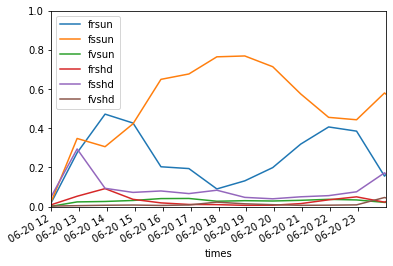

In [54]:
df.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=[pytz.utc.localize(datetime.strptime('202305290120000', '%Y%m%d%H%M%S')),pytz.utc.localize(datetime.strptime('20230529235959', '%Y%m%d%H%M%S'))],ylim=[0,1])

<AxesSubplot:xlabel='times'>

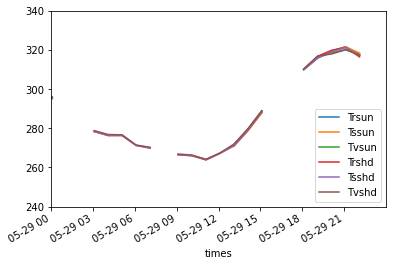

In [45]:
df.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=[pytz.utc.localize(datetime.strptime('20230529000000', '%Y%m%d%H%M%S')),pytz.utc.localize(datetime.strptime('20230529235959', '%Y%m%d%H%M%S'))],ylim=[240,340])